In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix


## Degree in Data Science and Engineering, group 96
## Double Degree in Data Science and Engineering
## & Engineering in Telecommunication Technologies, group 196
## Machine Learning 2
### Fall 2024

&nbsp;
&nbsp;
&nbsp;
# Lab 3. Customer Segmentation

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**, **David Martínez Rubio**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Introduction

---

The task to solve in this project is to segment a collection of users of a streaming service. This problem is usually found in **Recommender Systems**. The data set comes from a benchmark problem called [MovieLens](https://grouplens.org/datasets/movielens/).

The original data consists of a set of *ratings* between 1 and 5 points about movies carried out by users of the *MovieLens* web. We have simplified the problem generating a label equal to $+1$ for ratings greater or equal than $4$ and a label of $-1$ for ratings smaller than $4$.

The goal of the project is to find groups of users that share preferences by means of clustering algorithms and to try to interpret the resulting groups.

# Load dataset

---

The following cells load the csv files with the data into pandas dataframes and shows a few lines of each dataframe:

- `my_movies.csv`: set of rated movies. For each movie we have an identifier `movieId` and its title.

- `my_ratings.csv`: Each lines registers the rating given by the user identified with `userId` to the movie with identifier `movieId`. Column `label` indicates if `userId` liked the movie (label=$+1$) or not (label=$-1$).

In [ ]:
import pandas as pd
movies = pd.read_csv('movies.csv')
movies = movies.drop('genres', axis=1)
ratings = pd.read_csv('ratings.csv')
ratings['value'] = ratings['rating'].map(lambda x: -1 if x <= 2.5 else 1)
ratings = ratings.drop('rating', axis=1)
ratings = ratings.drop('timestamp', axis=1)
type(movies), type(ratings)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [6]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [7]:
ratings.head()

,userId,movieId,timestamp,value
0,1,1,964982703,1
1,1,3,964981247,1
2,1,6,964982224,1
3,1,47,964983815,1
4,1,50,964982931,1


# Finding a robust clustering with a little supervision

Clustering belongs to the non-supervised machine learning family. However, in order to have a means to assess the quality of the groups found by the clustering algorithms that you will use later, we propose the following means (sort of cross validation) to get a little supervision.

The underlying assumption is that the preferences of each user can be defined by the ratings in a way that if a user is presented with two separate sets of movies, the ratings given by this user to any of the two sets are equally informative to define this user's preferences.

In other words, you will implement the following strategy to evaluate the quality of the segmentation given by fitting a clustering method with a particular set of hyperparameters:

- Split the set of movies into two subset.

- For each combination of the hyperparameters that define the clustering model you will fit two instances of the model, one with each subset of movies.

- The above underlying assumption involves that if the set of hyperparameters leads to a good clustering, two two clusterings found for each subset will be very similar: If two users have very similar preferences, they will end up in the same group in both clusterings (conversely, if two users have different preferences, they will end up in different groups independently of the set of movies used to fit the clustering method).

- In order to use the similarity between the two clusterings as a proxy to assess the suitability of the hyperparameters, we suggest to measure this similarity with the [Mutual Information](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html).

# 1.- Split the movie set into two subsets


Obtain two lists: `idx_movies_1` and`idx_movies_2` with approximately the same number of movies.

Hint: sort the movies by number of ratings and put the even positions in a group and the odd positions in the other, so that both sets contain the same proportion of movies with many ratings and movies with few ratings.


In [11]:
### YOUR CODE
# Sort movies by number of ratings
movie_ratings_count = ratings['movieId'].value_counts()
print(movie_ratings_count)
sorted_movies = movie_ratings_count.index.tolist()

# Split into two subsets
idx_movies_1 = sorted_movies[::2]  # Even positions
idx_movies_2 = sorted_movies[1::2] # Odd positions

print(idx_movies_1,'\n')
print(idx_movies_2)


movieId
355       329
317       317
295       307
592       279
2570      278
         ... 
2989       20
318        20
4979       20
27659      20
106917     20
Name: count, Length: 1297, dtype: int64
[355, 295, 2570, 479, 588, 2958, 1195, 2857, 779, 1197, 1209, 456, 5951, 7152, 607, 379, 363, 376, 3577, 589, 343, 366, 58558, 594, 164, 1264, 1196, 6376, 315, 1720, 1135, 3792, 230, 4885, 1088, 1239, 1220, 33, 1212, 8960, 4994, 1096, 732, 4972, 5444, 1072, 585, 1526, 5988, 1967, 184, 348, 3995, 252, 923, 1257, 328, 4895, 1731, 1922, 60068, 110, 356, 2705, 1221, 777, 433, 4021, 911, 103, 338, 749, 3113, 3948, 6364, 4026, 2501, 550, 2395, 1916, 287, 5377, 1355, 3947, 1258, 48779, 20, 2915, 2323, 2010, 2790, 1245, 1390, 5217, 1306, 409, 94, 1218, 1100, 15, 299, 48393, 316, 1675, 61, 8635, 3051, 33492, 336, 46577, 1624, 593, 6332, 439, 2699, 3174, 2691, 8664, 1484, 35835, 3993, 50871, 45721, 1027, 63081, 6372, 234, 473, 3407, 4033, 519, 7146, 265, 1379, 2053, 3752, 4261, 35, 74457, 16, 1287

# 2.- Construction of the affinity matrices

The next step is to construct the matrices with the affinity between users that will be fed to the clustering algorithms.ientos.

## 2.1.- Matrix users $\times$ movies

These matrices have one row per user and one column per movie. Position $(i,j)$ of these matrices is the label that the $i$-th user gave to the $j$-th movie. We assume label =$0$ means user $i$ hasn't watched movie $j$.

Hint: use a [sparse representation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) for this matrix.

Create two matrices `user_movies_sparse_1` and `user_movies_sparse_2`, each with the movies in lists  `idx_movies_1` and`idx_movies_2`.

Check that in both cases all the users have their corresponding row and that each user has rated at least a movie in each matrix. If not, copy any of the movies missing in one list into the other. For instance, if user $i$ has no ratings in the movies in `user_movies_sparse_1` (because all the movies rated by this user are in  `idx_movies_2`), copy in `idx_movies_1` any/some of the movies in `idx_movies_2` rated by the user.

In [8]:
from scipy.sparse import csr_matrix

def create_user_movie_matrix(ratings_df, movie_ids):
    """Creates a user-movie matrix using specified movie IDs."""

    # Filter ratings for selected movies
    filtered_ratings = ratings_df[ratings_df['movieId'].isin(movie_ids)]

    # Create sparse matrix
    user_movie_matrix = csr_matrix((filtered_ratings['label'],
                                      (filtered_ratings['userId'],
                                       filtered_ratings['movieId'])))

    return user_movie_matrix

# Create matrices for both subsets
user_movies_sparse_1 = create_user_movie_matrix(ratings, idx_movies_1)
user_movies_sparse_2 = create_user_movie_matrix(ratings, idx_movies_2)

# Check for users with no ratings in either matrix and adjust
# ... (Code for this check and adjustment will be added below)
# Get users with no ratings in each matrix
users_no_ratings_1 = np.where(user_movies_sparse_1.getnnz(axis=1) == 0)[0]

users_no_ratings_2 = np.where(user_movies_sparse_2.getnnz(axis=1) == 0)[0]


# Adjust matrices
for user_id in users_no_ratings_1:
    # Get movie IDs rated by this user in the other subset
    movies_rated_by_user = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    movies_to_add = [movie_id for movie_id in movies_rated_by_user if movie_id in idx_movies_2]

    # Add a movie to idx_movies_1
    if movies_to_add:
        idx_movies_1.append(movies_to_add[0])
        # Recreate user_movies_sparse_1 with updated idx_movies_1
        user_movies_sparse_1 = create_user_movie_matrix(ratings, idx_movies_1)

# Similarly for users_no_ratings_2
# ... (Repeat the logic for users_no_ratings_2)

# Adjust matrices
for user_id in users_no_ratings_2:
    # Get movie IDs rated by this user in the other subset
    movies_rated_by_user = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    movies_to_add = [movie_id for movie_id in movies_rated_by_user if movie_id in idx_movies_2]

    # Add a movie to idx_movies_2
    if movies_to_add:
        idx_movies_2.append(movies_to_add[0])
        # Recreate user_movies_sparse_2 with updated idx_movies_2
        user_movies_sparse_2 = create_user_movie_matrix(ratings, idx_movies_1)

## 2.2.-  Jaccard similarity

The similarity function that will compare the users is based in the [*Jaccard Index*](https://en.wikipedia.org/wiki/Jaccard_index), commonly used in recommender systems. Basically it computes the similarity between two users as the number of movies for which they have given the same label divided by the number of movies that at least one of them has rated.

For instances, in a collection of 10 movies the rows of the users $\times$ movies matrix corresponding to  3 users $i$, $j$ and $k$ are:
- `users_movies[i,:] = [0,-1,0,0,0,1,0,0,1,0]`
- `users_movies[j,:] = [0,1,0,-1,-1,1,0,0,1,0]`
- `users_movies[k,:] = [0,1,0,0,0,0,0,0,1,0]`

Then the similarities would be:
- `s[i,j] = 2/5` as they gave the same label to 2 movies (6th and 9th) and they have rated 5 movies (2nd, 6th and 9th were rated by both users and 4th  and   5th were rated by user $j$)
- `s[i,k] = 1/3` as they gave the same label to 1 movie (9th) and they have rated 3 movies (2nd and  9th were rated by both users and  6th by user $i$)
- `s[k,j] = 2/5` as they gave the same label to 2 movies (2nd and 9th)   and they have rated 5 movies (2nd and 9th were rated by both users and 4th,  5th and 6th were rated by user $j$)

Write code that implements the computation of the jaccard similarity between the rows of an input matrix.

In [9]:
def jaccard_gram_matrix(X):
    """Computes the Jaccard similarity matrix for a given input matrix X (CSR matrix)."""

    n_users = X.shape[0]
    similarity_matrix = np.zeros((n_users, n_users))
    np.fill_diagonal(similarity_matrix,1)
    for i in range(n_users):
        for j in range(i + 1, n_users):# permits to have all the combination (i,j)

            # Efficiently get non-zero indices and data for users i and j
            user_i_indices = X[i,:].indices
            user_i_data = X[i,:].data
            user_j_indices = X[j,:].indices
            user_j_data = X[j,:].data

            # Find common movies and calculate intersection
            common_movies = np.intersect1d(user_i_indices, user_j_indices)
            intersection = np.sum(user_i_data[np.isin(user_i_indices, common_movies)] ==
                                 user_j_data[np.isin(user_j_indices, common_movies)])

            # Calculate union
            union = len(user_i_indices) + len(user_j_indices) - len(common_movies)

            if union > 0:
                similarity = intersection / union
            else:
                similarity = 0

            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity


    return similarity_matrix

Use the function to compute `useruser1` and `useruser2`, the affinity matrices correspoding to `user_movies_sparse_1` and `user_movies_sparse_2`

In [12]:
### YOUR CODE
useuser1 = jaccard_gram_matrix(user_movies_sparse_1)

useruser2 = jaccard_gram_matrix(user_movies_sparse_2)

In [13]:
print(useuser1)

[[1.         0.01904762 0.00952381 ... 0.07831325 0.02884615 0.09404389]
 [0.01904762 1.         0.         ... 0.00653595 0.         0.02255639]
 [0.00952381 0.         1.         ... 0.01980198 0.         0.00732601]
 ...
 [0.07831325 0.00653595 0.01980198 ... 1.         0.03010033 0.15690867]
 [0.02884615 0.         0.         ... 0.03010033 1.         0.00738007]
 [0.09404389 0.02255639 0.00732601 ... 0.15690867 0.00738007 1.        ]]


# 3.- Spectral Clustering based in the *Jaccard* similarity

# 3.1.- Determine the reasonable values for the hyperparameters


This clustering method has a single hyperparameter, **the number of groups**. A reasonable range for its value can be $[2,3,4,5,6,7,8,9,10, 12, 15, 20]$. A larger number of groups wouldn't be easy to manage. Moreover, the groups should be meaningful in the sense that at least a minimum number of 20-30 users per group would be indicative of the group capturing a pattern.


## 3.2.- Determine the number of groups

Write code that, for each value of `n_clusters` in the range for the number of groups:
- Fits an spectral clustering with `useruser1`
- Let us call `clustering1` to an array with the group memberships of the users. That is, `clustering1[i]=k` means that user $i$ is in cluster $k$.
- Fits an spectral clustering with  `useruser2`
- Let us call `clustering2` to an array with the group memberships of the users. That is, `clustering2[i]=k` means that user $i$ is in cluster $k$.
- Compute the mutual information between `clustering1` and `clustering2`
- Check that the size of the smallest cluster is reasonable

In [19]:
### YOUR CODE
from sklearn.cluster import SpectralClustering
from sklearn.metrics import mutual_info_score

# Range of cluster numbers to explore
n_clusters_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]

# Store results
results = []

for n_clusters in n_clusters_range:
    # Fit spectral clustering for both affinity matrices
    clustering1 = SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit_predict(useuser1)
    clustering2 = SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit_predict(useruser2)

    # Calculate mutual information
    mi_score = mutual_info_score(clustering1, clustering2)

    # Check cluster sizes
    cluster_sizes1 = np.bincount(clustering1)
    cluster_sizes2 = np.bincount(clustering2)
    min_cluster_size1 = np.min(cluster_sizes1)
    min_cluster_size2 = np.min(cluster_sizes2)

    # Store results
    results.append({
        'n_clusters': n_clusters,
        'mi_score': mi_score,
        'min_cluster_size1': min_cluster_size1,
        'min_cluster_size2': min_cluster_size2
    })

print("Results for n_clusters in the range:")
res = pd.DataFrame(results)
print(res)
print(clustering1)

# Analyze results (e.g., find the best n_clusters)
# ... (Code to analyze results and decide on the best n_clusters)

Results for n_clusters in the range:
    n_clusters  mi_score  min_cluster_size1  min_cluster_size2
0            2  0.414345                128                132
1            3  0.418352                 23                101
2            4  0.717380                 23                 26
3            5  0.728485                 23                 26
4            6  0.637921                  3                 14
5            7  0.648355                  2                  2
6            8  0.659107                  1                  1
7            9  0.751756                  1                  1
8           10  0.704715                  1                  1
9           12  0.758106                  1                  1
10          15  0.898008                  1                  1
11          20  0.552973                  1                  1
[ 4 10  7  4  4  4  4  4  3  3  2 16  0  2  4 10  4  4  4  4  4  2 10  4
  3  4  4  4  4  3  4  4  4  4  4 12  4  4  4  4  4  4  4 14  4  4  2  

**Decide the best number of groups according to the criteria discussed above**. Compare this number with the elbow in the plot of the eigenvalues of matrices `useruser1` and `useruser2`

Best n_clusters based on MI and cluster size: 5
MI score for best n_clusters: 0.7316894356351094
26.700095467922505
[3.071965101452083, 3.1001860617866344, 3.176659178139653, 3.4987214379414, 3.578550114807016, 3.7148032439762173, 4.19555013930882, 4.420943315344467, 5.310366350242871, 6.287378760703563, 8.40311453883867, 13.581969728258157, 26.70109513140644]


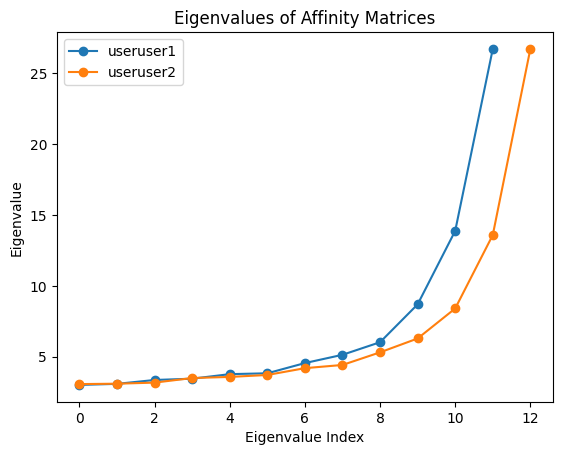

In [15]:
### YOUR CODE
## We see that the best MI score is obtained with more and more clusters but we have to satisfy
##the minimum size of the prior which must be greater than 20
## So 5 clusters !!
import pandas as pd

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Filter for reasonable cluster sizes (e.g., minimum size >= 20)
filtered_results = results_df[(results_df['min_cluster_size1'] >= 20) &
                              (results_df['min_cluster_size2'] >= 20)]

# Find the n_clusters with the highest MI score in the filtered results
best_n_clusters = filtered_results.loc[filtered_results['mi_score'].idxmax(), 'n_clusters']

print(f"Best n_clusters based on MI and cluster size: {best_n_clusters}")
print(f"MI score for best n_clusters: {filtered_results.loc[filtered_results['mi_score'].idxmax(), 'mi_score']}")
from scipy.sparse.linalg import eigsh

# Calculate eigenvalues for useruser1
eigenvalues1 = eigsh(useuser1, k=min(20, useuser1.shape[0] - 1), return_eigenvectors=False)

# Calculate eigenvalues for useruser2
eigenvalues2 = eigsh(useruser2, k=min(20, useruser2.shape[0] - 1), return_eigenvectors=False)

# Set the eigenvalue threshold
eigenvalue_threshold = 3# Example threshold

# Keep eigenvalues above the threshold for useruser1
eigenvalues1_filtered = [ev for ev in eigenvalues1 if ev >= eigenvalue_threshold]

# Keep eigenvalues above the threshold for useruser2
eigenvalues2_filtered = [ev for ev in eigenvalues2 if ev >= eigenvalue_threshold]
print(eigenvalues1_filtered[-1])
print(eigenvalues2_filtered)
# Plot eigenvalues
plt.plot(eigenvalues1_filtered, marker='o', label='useruser1')
plt.plot(eigenvalues2_filtered, marker='o', label='useruser2')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Affinity Matrices')
plt.legend()
plt.show()

# 4.-  Spectral Clustering with  graph neighbors


Now explore modifications of the affinity matrix for the spectral clustering by fixing the number of neighbors in each row. Starting with the Jaccard affinity matrix, and use `affinity='precomputed_nearest_neighbors'`
and `n_neighbors` in the range [5,10,20,50,100,150,200].

Use the supervision decribed in section 3.2 to find good values for the numbr of groups and the number of graph neighbors

In [16]:
### YOUR CODE
from sklearn.cluster import SpectralClustering
from sklearn.metrics import mutual_info_score
from sklearn.neighbors import kneighbors_graph

# Range of n_neighbors to explore
n_neighbors_range = [5, 10, 20, 50, 100, 150, 200]

# Store results
results_neighbors = []

for n_neighbors in n_neighbors_range:
    # Create graph neighbor affinity matrices
    affinity_matrix1 = kneighbors_graph(useuser1, n_neighbors=n_neighbors, include_self=True)
    affinity_matrix2 = kneighbors_graph(useruser2, n_neighbors=n_neighbors, include_self=True)

    for n_clusters in n_clusters_range:  # Using the same n_clusters_range as before
        # Fit spectral clustering
        clustering1 = SpectralClustering(n_clusters=n_clusters, affinity='precomputed_nearest_neighbors', n_neighbors=n_neighbors).fit_predict(affinity_matrix1)
        clustering2 = SpectralClustering(n_clusters=n_clusters, affinity='precomputed_nearest_neighbors', n_neighbors=n_neighbors).fit_predict(affinity_matrix2)

        # Calculate mutual information and cluster sizes (same as before)
        mi_score = mutual_info_score(clustering1, clustering2)
        cluster_sizes1 = np.bincount(clustering1)
        cluster_sizes2 = np.bincount(clustering2)
        min_cluster_size1 = np.min(cluster_sizes1)
        min_cluster_size2 = np.min(cluster_sizes2)

        # Store results
        results_neighbors.append({
            'n_neighbors': n_neighbors,
            'n_clusters': n_clusters,
            'mi_score': mi_score,
            'min_cluster_size1': min_cluster_size1,
            'min_cluster_size2': min_cluster_size2
        })

res = pd.DataFrame(results_neighbors)
print(res)
# Analyze results_neighbors to find best hyperparameters
# ... (Code to analyze results and decide on the best n_neighbors and n_clusters)

    n_neighbors  n_clusters  mi_score  min_cluster_size1  min_cluster_size2
0             5           2  0.387678                 91                 93
1             5           3  0.522010                 22                 25
2             5           4  0.808822                 22                 25
3             5           5  0.894979                 22                 25
4             5           6  1.102942                 22                 25
..          ...         ...       ...                ...                ...
79          200           9  1.212302                 31                 27
80          200          10  1.295472                 30                 27
81          200          12  1.339981                 25                 16
82          200          15  1.418149                 12                 14
83          200          20  1.390173                  6                  7

[84 rows x 5 columns]


In [17]:
### YOUR CODE
filtered_results_neighbors = res[(res['min_cluster_size1'] >= 20) &
                              (res['min_cluster_size2'] >= 20)]

print("the best n_neighbors and n_clusters based on MI and cluster size:", filtered_results_neighbors.loc[filtered_results_neighbors['mi_score'].idxmax(), ['n_neighbors', 'n_clusters','mi_score']])
best_n_cluster = filtered_results_neighbors.loc[filtered_results_neighbors['mi_score'].idxmax(), 'n_clusters']
best_n_neighbor = filtered_results_neighbors.loc[filtered_results_neighbors['mi_score'].idxmax(), 'n_neighbors']

the best n_neighbors and n_clusters based on MI and cluster size: n_neighbors    50.000000
n_clusters     15.000000
mi_score        1.553027
Name: 46, dtype: float64


For the same number of clusters (and providing the size of the smallest group is reasonable), is there any number of neighbors that beats the spectral clustering of section 3.2 in terms of Mutual Information between the two partitions?

# 5.- Final clustering

Decide what will be the final spectral clustering model, the one based in sectin 3.2 or the graph neighbors based of section 4.


Build the overall sparse affinity matrix `useruser` with the Jaccard index and all the movies.

In [18]:
### YOUR CODE
## The best one is section 4
# Create user-movie matrix with all movies
user_movies_sparse_all = create_user_movie_matrix(ratings, movies['movieId'].tolist())

# Calculate Jaccard similarity matrix
useruser = jaccard_gram_matrix(user_movies_sparse_all)

Fit the final spectral clustering with the best hyperparamters found before.

In [20]:
### YOUR CODE
affinity_matrix1 = kneighbors_graph(useruser, n_neighbors=best_n_neighbor, include_self=True)


# Fit spectral clustering
final_clustering = SpectralClustering(n_clusters=best_n_cluster, affinity='precomputed_nearest_neighbors', n_neighbors=best_n_neighbor).fit_predict(affinity_matrix1)
print(final_clustering)
# Supposons que vous ayez les assignations de cluster finales dans une variable appelée 'final_clustering'
# et que les IDs uniques soient dans une variable appelée 'unique_ids'
unique_ids = ratings['userId'].unique()
# Créer un dictionnaire pour mapper les IDs uniques à leurs clusters
id_to_cluster = dict(zip(unique_ids, final_clustering))

# Ajouter la nouvelle colonne 'cluster' à 'ratings' en utilisant le mappage
ratings['cluster'] = ratings['userId'].map(id_to_cluster)
print(ratings)


[ 4  1  0  7  3  3 10  3 11  1 14  0 11  3 10  2  8  6  4 13 13 13  7 10
  9 12  7  6  7  9  5 14 14 13 14  0 12  3  7  3 13  4  3  5  4 12 13 11
  9 13  7 10  0 12  0 12  4  3  7 11  2 10  6  6  9  4  9  6 14  2  5  8
 10  7 11  2  9 14 14 10 12 13 10  4  0  8  0  9 13  5  6  0 14  3  7 14
 11  1 12  7 11  3  6 13 10  1 12 11  3  2 13 14  7  1 14 14  3  2 10  5
  3 10  9  2 10 12  0  7 10 12  2  6 12 12  4  3  7  0 13  4 10 12  1  8
 12  0  0  1 11  5  5  2 13  1 11  4 11  0 13  4  0 14  0 14 11  8 13  7
 13  3 14 11 12  3  0 12  6  8  3 11  3  6 14  1 11  4  8  0  9  2 14 12
  2  0  4 11 11  4  4  6 14  4 11  2  1  5  0 11  9 10 10 10 11  5  2  7
  4 11  6  8  7 13 13  7 11  6  2 11  3 13  9  6  8 14  3  0 11  0  8  3
  2 12 14 14  0 10  8  1  6  0  2  1  0  8  0 10  0  9 11  7  2  5  8 11
 14  4 14  7  5  5  0  1  3  6  4  5  5 11 10 13  0  8 14  3  7  8 13  6
  0  7  1  6  0  4  2  2 14  6 11  2  8  5 11  4  6  1  6 13  7 11  0  4
  4  3  0 11  8  6  9  0  3  2 14  0  7  2  2  6  0

# 6.- Interpretation based on average votes

For each group in the previous section, print the 10 movies that obtain a higher average label among the users in the group (movies loved by users in this group) and the 10 movies with the lowest average label (movies hated by users in this group).

In [ ]:
### YOUR CODE
# Assuming you have the final clustering assignments in a variable called 'final_clustering'

# Get unique cluster labels
unique_clusters = np.unique(final_clustering)

# Iterate through each cluster
for cluster_id in unique_clusters:
    cluster_ratings = ratings.loc[ratings['cluster'] == cluster_id]
    # Calculate average label for each movie
    average_labels = cluster_ratings.groupby('movieId')['label'].mean()

    # Get top 10 loved and hated movies
    top_loved = average_labels.sort_values(ascending=False).head(10)
    top_hated = average_labels.sort_values(ascending=True).head(10)

    # Print results
    print(f"Cluster {cluster_id}:")
    print("Top 10 Loved Movies:")
    print(movies[movies['movieId'].isin(top_loved.index)]['title'])  # Get movie titles
    print("\nTop 10 Hated Movies:")
    print(movies[movies['movieId'].isin(top_hated.index)]['title'])  # Get movie titles
    print("\n")

# 7.- Interpretation based in classification

The hated or loved movies lists in the previous section present repeated items. Those movies get a lot of labels in general independently of the group of users we look at. Therefore these movies are not very representative of any of the groups of users.

In this section you will use a classifier in which one can easily infer the relevance of the features (such as random forest) in order to find the most representative movies from each cluster.

For each group of users from section 5:
- Create an array with binary classification *targets* with length equal to the number of users. This array will have a positive target ($+1$) in the positions corresponding to users members of the group, and a negative lable in the positions corresponding to the non-members of the group.

- Fit a random forest with a hyperparameter set that forces an accuracy in the traninig set close to 1. Use the users $\times$ movies matrix as observations with the targets in the previous bullet point.

- Get the relevance of each movie in the classification from attribute `feature_importances_`.

- Build a DataFrame with the 10 most relevant movies showing for each of them:
    - Title
    - value of `feature_importances_`
    - Average label from the members of the group
    - Average label from the non-members of the group



In [ ]:
### YOUR CODE
from sklearn.ensemble import RandomForestClassifier

# Get unique cluster labels
unique_clusters = np.unique(final_clustering)

# Iterate through each cluster
for cluster_id in unique_clusters:
    # Create binary targets for classification
    targets = np.where(final_clustering == cluster_id, 1, 0)  # 1 for cluster members, 0 for others

    # Fit Random Forest classifier with high accuracy
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed
    rf_classifier.fit(user_movies_sparse_all, targets)

    # Get feature importances (movie relevance)
    feature_importances = rf_classifier.feature_importances_

    # Get top 10 most relevant movies
    top_movie_indices = np.argsort(feature_importances)[-10:]  # Indices of top 10 movies

    # Create DataFrame for results
    results_df = pd.DataFrame({
        'title': movies.loc[movies['movieId'].isin(top_movie_indices), 'title'].values,
        'feature_importance': feature_importances[top_movie_indices],
        'avg_label_cluster': average_labels[top_movie_indices],  # Assuming you have 'average_labels'
        'avg_label_others': ratings[ratings['cluster'] != cluster_id].groupby('movieId')['label'].mean()[top_movie_indices]
    })

    # Print results
    print(f"Cluster {cluster_id}:")
    print(results_df)
    print("\n")